In [10]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC

from mlxtend.classifier import StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import plotly.express as px
from matplotlib import pyplot as plt
import scikitplot as skplt
import missingno as msno
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

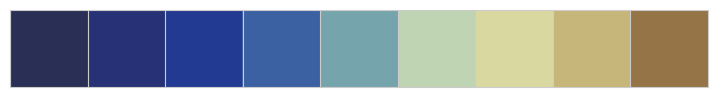

In [11]:
cm = ["#273176","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1"]
gradient = ["#292F55","#273176","#223A92","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1","#C7B679","#957447"]
sns.palplot(gradient)

In [12]:
path = "C:/Users/antoi/Desktop/Machine_LearningProjet/data/"
df_tr = pd.read_csv(f"{path}train.csv").set_index("PassengerId", drop=True)
df_ts = pd.read_csv(f"{path}test.csv").set_index("PassengerId", drop=True)
df = pd.concat([df_tr, df_ts], axis=0)
df.head(10).style.background_gradient(cmap='Blues')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.000000,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
2,1.000000,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
3,1.000000,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
4,1.000000,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
5,0.000000,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S
6,0.000000,3,"Moran, Mr. James",male,nan,0,0,330877,8.458300,nan,Q
7,0.000000,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.862500,E46,S
8,0.000000,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.075000,nan,S
9,1.000000,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.133300,nan,S


<Axes: >

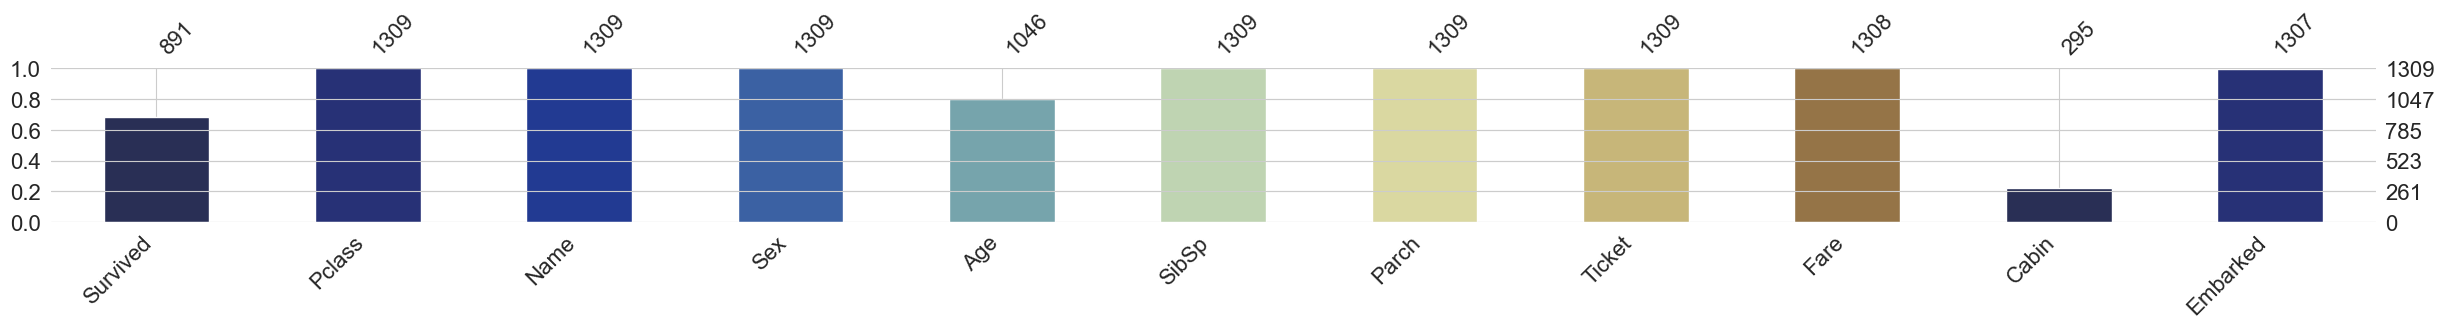

In [13]:
msno.bar(df, figsize=(30,2), color=gradient)

In [14]:
df["Deck"] = df["Cabin"].str[:1]
df["Deck"] = df["Deck"].replace(np.nan,"N/A")
print("All Deck descriptors:")
print(set(df["Deck"].values))

All Deck descriptors:
{'F', 'N/A', 'C', 'A', 'E', 'D', 'T', 'B', 'G'}


In [15]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
dfplt = dfplt[dfplt["Deck"]!="N/A"]
fig = px.histogram(dfplt, x="Deck",color="Survived",
                   color_discrete_sequence=cm)
fig.show()

In [16]:
df.loc[df["Deck"]=='T',"Deck"] = 'N/A'

In [17]:
replaces = {'B51 B53 B55': 'B55', 'B52 B54 B56': 'B56', 'B57 B59 B63 B66': 'B66', 'B58 B60': 'B60', 
            'B82 B84': 'B84', 'B96 B98': 'B98', 'C22 C26': 'C26', 'C23 C25 C27': 'C27', 'C55 C57': 'C57',
            'C62 C64': 'C64', 'D10 D12': 'D12', 'E39 E41': 'E41', 'F E46': 'E46', 'F E57': 'E57',
            'F E69': 'E69', 'F G63': 'G63', 'F G73': 'G73', 'F': None, 'D': None, ' ': None, 'T': None, np.nan: None}
df["Cabin"] = df["Cabin"].replace(replaces)
df["Cabin"] = df.fillna(np.nan)["Cabin"].str[1:].astype(float)

In [18]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.histogram(dfplt, x="Cabin",color="Survived", height=300,
                   color_discrete_sequence=cm)
fig.show()

In [19]:
df["Side"] = df["Cabin"]
df.loc[df["Side"]!=0,"Side"] = (df["Cabin"][df["Cabin"]!=0]%2-0.5)*2

s = df[df["Side"]==1]
print(f'Survived for side 1\t {len(s[s["Survived"]==1])/len(s)}')
s = df[df["Side"]==-1]
print(f'Survived for side -1\t {len(s[s["Survived"]==1])/len(s)}')

Survived for side 1	 0.5076923076923077
Survived for side -1	 0.4276729559748428


In [20]:
for i in set(df["Deck"].values):
    v = df[df["Deck"]==i]["Cabin"]//2
    df.loc[df["Deck"]==i, "Cabin"]= v
    df.loc[(df["Deck"]==i) & (df["Cabin"]==0),"Cabin"] = np.median(v)
    
df.loc[df["Cabin"].isna(),"Cabin"]=-1
df["Cabin"] = df["Cabin"].astype(int)

In [21]:
dfplt = df.copy(deep=True)
dfplt = dfplt[~dfplt["Survived"].isna()]
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter_3d(dfplt, x="Cabin", y="Side", z= "Deck", color="Survived",
                    color_discrete_sequence=cm, size_max=6, width=1000, height=1000)
fig.show()

<Axes: >

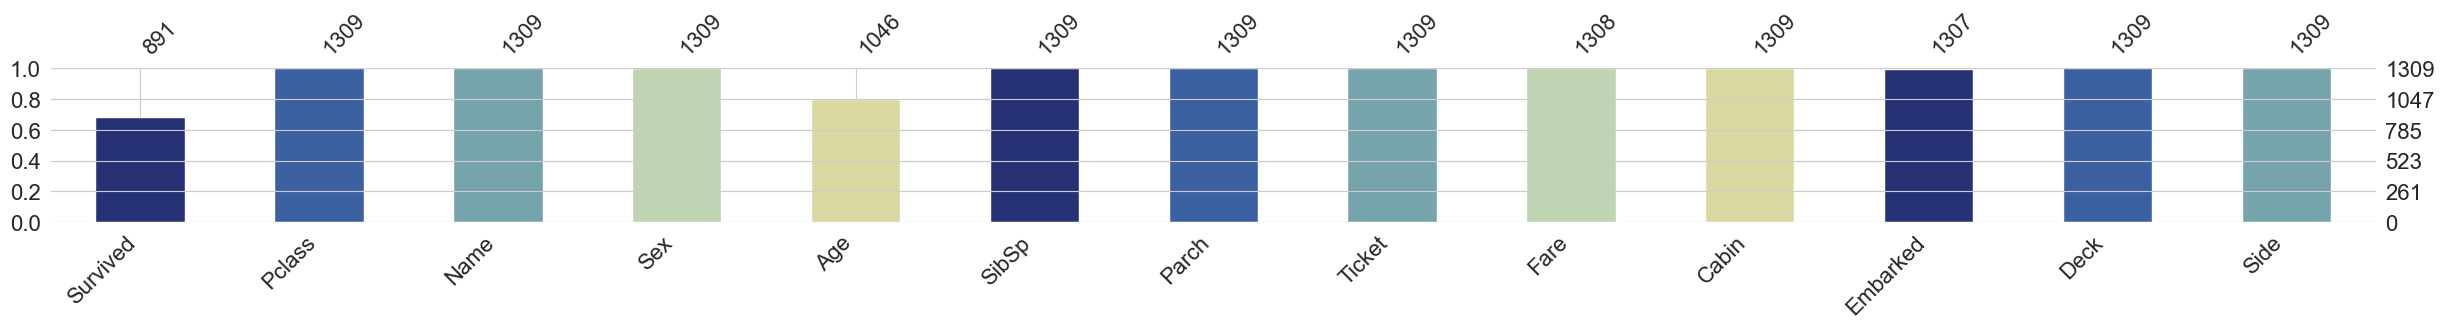

In [22]:
df["Side"] = df["Side"].fillna(0)
msno.bar(df, figsize=(30,2), color=cm)

In [23]:
lin_rep = lambda x: x.replace({'LINE':"370160"})
df = lin_rep(df)

In [24]:
prefixes = []
nums, prefs = [],[]
for i in df["Ticket"].values:   
    if not i.isdigit():
        nums.append(int(re.search('.* {1}([0-9]+)', i).groups()[0]))
        prefix = re.search('(.*)( {1})[0-9]+', i).groups()[0]
        prefs.append(prefix.replace(".","").replace(" ", "").replace("/","")) # Needed to put in one group such prefixes as "A/5", "A/5.", "A.5" etc.
    else:
        nums.append(int(i))
        prefs.append("")
df["Ticket"] = nums
df["Ticket_p"] = prefs

In [25]:
dfplt = df.copy(deep=True)
fig = px.scatter(dfplt.astype(str), x="Ticket_p", y="Name", color= "Survived",
                 color_discrete_sequence=cm, size_max=6,width=1200, height=500)
fig.show()

In [26]:
drop = ["SP", "SOP", "Fa", "SCOW", "PPP", "AS", "CASOTON", "SWPP", "SCAHBasle", "SCA3", "STONOQ", "AQ4", "A2", "LP", "AQ3", ""]
df = df.replace(drop, 'N/A')

In [27]:
dfplt = df.copy(deep=True)
dfplt= dfplt[dfplt["Ticket_p"] != "N/A"]
fig = px.scatter(dfplt.astype(str), x="Ticket_p", y="Name", color= "Survived",
                 color_discrete_sequence=cm, size_max=6,width=1200, height=500)
fig.show()

In [28]:
df[["Surname","Name"]] = [i.split(",") for i in df["Name"].values]

In [29]:
a = df.groupby("Surname")["Surname"].count()
fam_list = a[a>1].index.values
df.loc[~df["Surname"].isin(fam_list),"Surname"] = "Other"

In [30]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
dfplt = dfplt[dfplt["Surname"]!="Other"]
fig = px.histogram(dfplt, x="Surname",color="Survived",color_discrete_sequence=cm)
fig.show()

In [31]:
df["Namesakes"] = 1
df.loc[df["Surname"]=="Other","Namesakes"] = 0

In [32]:
not_imp_s = ["Braund","Allen","Moran","Meyer","Holverson","Turpin","Arnold-Franchi","Panula","Harris","Skoog","Kantor","Petroff","Gustafsson","Zabour",
             "Jussila","Attalah","Baxter","Hickman","Nasser","Futrelle","Navratil","Calic","Bourke","Strom","Backstrom","Ali","Jacobsohn","Larsson",
             "Carter","Lobb","Taussig","Johnson","Abelson","Hart","Graham","Pears","Barbara","O'Brien","Hakkarainen","Van Impe","Flynn","Silvey","Hagland",
             "Morley","Renouf","Stanley","Penasco y Castellana","Webber","Coleff","Yasbeck","Collyer","Thorneycroft","Jensen","Newell","Saad","Thayer","Hoyt",
             "Andrews","Lam","Harper","Nicola-Yarred","Doling","Hamalainen","Beckwith","Mellinger","Bishop","Hippach","Richards","Baclini","Goldenberg",
             "Beane","Duff Gordon","Tylor","Dick","Chambers","Moor","Snyder", "Howard", "Jefferys", "Franklin","Abelseth","Straus","Khalil","Dyker","Stengel",
             "Foley","Buckley","Zakarian","Peacock","Mahon","Clark","Pokrnic","Ware","Gibson","Taylor"]
df = df.replace(not_imp_s,'Other')

In [33]:
df[(df["Surname"]=="Other") & (df["Namesakes"]==True)].head(10).style.background_gradient(cmap="Blues")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Side,Ticket_p,Surname,Namesakes
PassengerId,,,,,,,,,,,,,,,,
1,0.000000,3,Mr. Owen Harris,male,22.000000,1,0,21171,7.250000,-1,S,N/A,0.000000,A5,Other,1
4,1.000000,1,Mrs. Jacques Heath (Lily May Peel),female,35.000000,1,0,113803,53.100000,61,S,C,1.000000,N/A,Other,1
5,0.000000,3,Mr. William Henry,male,35.000000,0,0,373450,8.050000,-1,S,N/A,0.000000,N/A,Other,1
6,0.000000,3,Mr. James,male,nan,0,0,330877,8.458300,-1,Q,N/A,0.000000,N/A,Other,1
9,1.000000,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg),female,27.000000,0,2,347742,11.133300,-1,S,N/A,0.000000,N/A,Other,1
10,1.000000,2,Mrs. Nicholas (Adele Achem),female,14.000000,1,0,237736,30.070800,-1,C,N/A,0.000000,N/A,Other,1
35,0.000000,1,Mr. Edgar Joseph,male,28.000000,1,0,17604,82.170800,-1,C,N/A,0.000000,PC,Other,1
36,0.000000,1,Mr. Alexander Oskar,male,42.000000,1,0,113789,52.000000,-1,S,N/A,0.000000,N/A,Other,1
40,1.000000,3,Miss. Jamila,female,14.000000,1,0,2651,11.241700,-1,C,N/A,0.000000,N/A,Other,1


In [34]:
s = df[df["Namesakes"]==0]
print(f'Have no Namesakes \t {len(s[s["Survived"]==1])/len(s)}')
s = df[df["Namesakes"]==1]
print(f'Have Namesakes \t\t {len(s[s["Survived"]==1])/len(s)}')

Have no Namesakes 	 0.23390894819466249
Have Namesakes 		 0.28720238095238093


In [35]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
dfplt = dfplt[dfplt["Surname"]!="Other"]
fig = px.histogram(dfplt, x="Surname",color="Survived",color_discrete_sequence=cm)
fig.show()

In [36]:
drop = ["Abbott","Keane","Minahan","Crosby","Hocking","Dean","Mallet",""]
df = df.replace(drop,'Other')

In [37]:
df["Title"] = pd.DataFrame(df["Name"].str.strip().str.split(".").tolist()).set_index(df.index).iloc[:,0]
df["Title"] = df["Title"].fillna("Others")

In [38]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.histogram(dfplt, x="Title",color="Survived",color_discrete_sequence=cm)
fig.show()

In [39]:
rename = {"Miss":"Ms",
          "Mrs": "Mme",
          "Others": ["Don","Rev","Dr","Lady","Sir","Mlle","Col","the Countess","Mme","Major","Capt","Jonkheer","Dona"]}
for k in rename:
    df["Title"] = df["Title"].replace(rename[k],k)

In [40]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.histogram(dfplt, x="Title",color="Survived",color_discrete_sequence=cm)
fig.show()

In [41]:
dfplt = df.copy(deep=True)
dfplt = dfplt[~dfplt["Survived"].isna()]
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter(dfplt, x="Age", y="Parch", color = "Survived", size_max=6
                 ,color_discrete_sequence=cm,width=1200, height=500)
fig.show()

In [42]:
df[(df["Age"]==5) & (df["Parch"]==0)]
# 5 y.o child traveling by hereself?

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Side,Ticket_p,Surname,Namesakes,Title
PassengerId,,,,,,,,,,,,,,,,,
778,1.0,3,Miss. Virginia Ethel,female,5.0,0,0,364516,12.475,-1,S,N/A,0.0,N/A,Other,0,Miss


In [43]:
#df.loc[df["Name"]=="Emanuel, Miss. Virginia Ethel","Parch"]=1
#df.loc[df["Name"]=="Dowdell, Miss. Elizabeth","Parch"]=1

#df.loc[df["Name"]=="Albimona, Mr. Nassef Cassem","Parch"]=1
#df.loc[df["Name"]=="Hassan, Mr. Houssein G N","Parch"]=1

#df.loc[df["Name"]=='Watt, Mrs. James (Elizabeth "Bessie" Inglis Milne)',"Parch"]=1
#df.loc[df["Name"]=="Watt, Miss. Bertha J","Parch"]=1

In [44]:
df["Kid"]=0
df.loc[(df["Age"]<18),"Kid"]=1
print(f'Kids survived koeff:\t{len(df[(df["Kid"]==1) & (df["Survived"]==0)])/len(df[(df["Kid"]==1) & (df["Survived"]==1)])}')
print(f'Others survived koeff:\t{len(df[(df["Kid"]==0) & (df["Survived"]==0)])/len(df[(df["Kid"]==0) & (df["Survived"]==1)])}')

Kids survived koeff:	0.8524590163934426
Others survived koeff:	1.7686832740213523


In [45]:
df["Old"]=0
df.loc[(df["Age"]>60),"Old"]=1
print(f'Elder survived koeff:\t{len(df[(df["Old"]==1) & (df["Survived"]==0)])/len(df[(df["Old"]==1) & (df["Survived"]==1)])}')
print(f'Others survived koeff:\t{len(df[(df["Old"]==0) & (df["Survived"]==0)])/len(df[(df["Old"]==0) & (df["Survived"]==1)])}')

Elder survived koeff:	3.4
Others survived koeff:	1.5786350148367954


In [46]:
df["Alone"] = 0
df.loc[(df["Parch"]==0) & (df["SibSp"]==0),"Alone"]=1
print(f'Alone survived koeff:\t\t{len(df[(df["Alone"]==1) & (df["Survived"]==0)])/len(df[(df["Alone"]==1) & (df["Survived"]==1)])}')
print(f'Not Alone survived koeff:\t{len(df[(df["Alone"]==0) & (df["Survived"]==0)])/len(df[(df["Alone"]==0) & (df["Survived"]==1)])}')

Alone survived koeff:		2.294478527607362
Not Alone survived koeff:	0.9776536312849162


<Axes: >

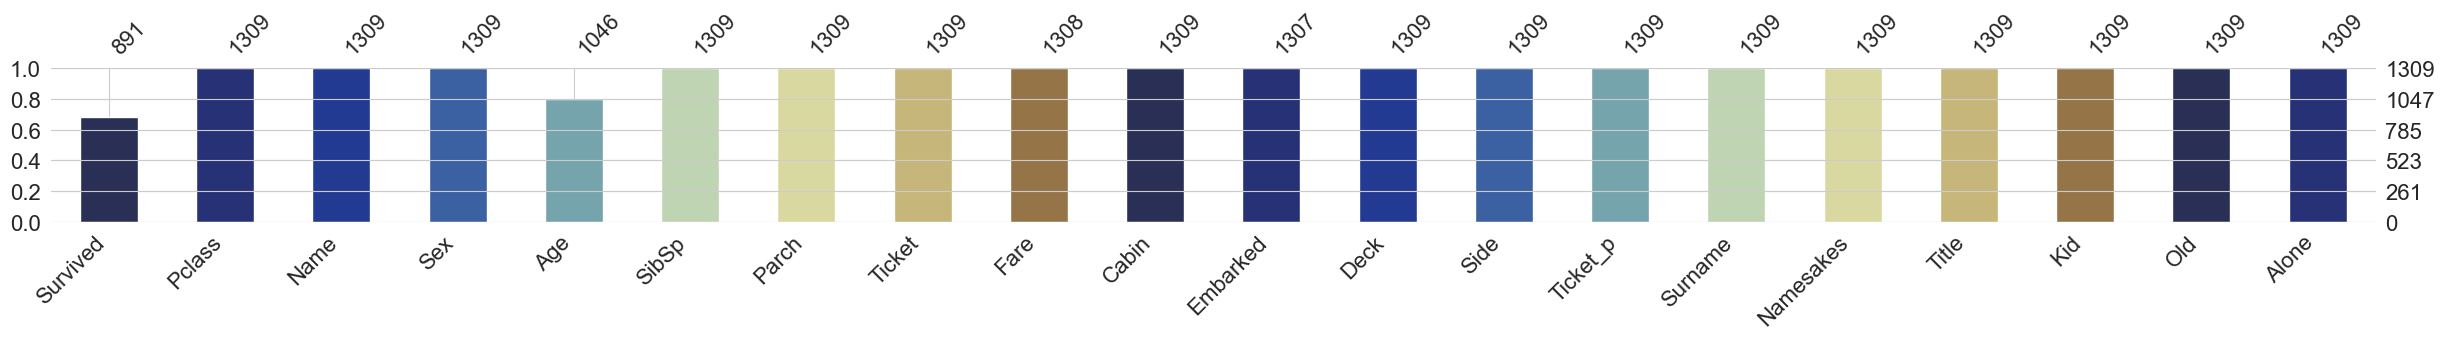

In [47]:
msno.bar(df, figsize=(30,2), color=gradient)

In [48]:
print(df[(df["Pclass"]==1) & (df["Sex"]=="female")]["Age"].median())
print(df[(df["Pclass"]==1) & (df["Sex"]=="male")]["Age"].median())
print(df[(df["Pclass"]==2) & (df["Sex"]=="female")]["Age"].median())
print(df[(df["Pclass"]==2) & (df["Sex"]=="male")]["Age"].median())
print(df[(df["Pclass"]==3) & (df["Sex"]=="female")]["Age"].median())
print(df[(df["Pclass"]==3) & (df["Sex"]=="male")]["Age"].median())

36.0
42.0
28.0
29.5
22.0
25.0


In [49]:
from itertools import *
l1, l2 = [1,2,3], ["female","male"]
for c,s in product(l1,l2):
    msk = (df["Pclass"]==c) & (df["Sex"]==s)
    df.loc[msk,"Age"] = df[msk]["Age"].fillna(df[msk]["Age"].median())

In [50]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter(dfplt, x="Age", y="Name", color = "Survived", size_max=6,
                 width=1200, height=500,color_discrete_sequence=cm)
fig.show()

In [51]:
print(df.loc[1044])
df.loc[1044,"Fare"] = df[df["Pclass"]==3]["Fare"].mean()

Survived             NaN
Pclass                 3
Name          Mr. Thomas
Sex                 male
Age                 60.5
SibSp                  0
Parch                  0
Ticket              3701
Fare                 NaN
Cabin                 -1
Embarked               S
Deck                 N/A
Side                 0.0
Ticket_p             N/A
Surname            Other
Namesakes              0
Title                 Mr
Kid                    0
Old                    1
Alone                  1
Name: 1044, dtype: object


In [52]:
df["Fare"] = df["Fare"].rank(method='max')

In [53]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter(dfplt, x="Fare", y="Name", color = "Survived", size_max=6,
                 width=1200, height=500,color_discrete_sequence=cm)
fig.show()

In [55]:
df.loc[df["Embarked"].isna(),"Embarked"] = "S"

In [56]:
onehot_df = pd.DataFrame(index=df.index)

for c in ["Pclass","Sex","Embarked","Deck","Ticket_p","Surname","Title"]:
    encoded = OneHotEncoder().fit_transform(df[c].to_numpy().reshape(-1,1)).toarray()
    columns = [f"{c}_{i}" for i in range(encoded.shape[1])]
    _df =pd.DataFrame(data=encoded, columns=columns, index=df.index)
    onehot_df = pd.concat([_df,onehot_df], axis=1)
    
onehot_df = pd.concat([onehot_df,df[["Survived","Age","SibSp","Parch","Fare","Cabin","Namesakes","Kid","Alone","Side"]]], axis=1)

for c in ["Age","Fare","Cabin","SibSp","Parch"]:
    onehot_df[c] = MinMaxScaler().fit_transform(onehot_df[c].to_numpy().reshape(-1,1))

In [57]:
onehot_df.head(10).style.background_gradient(cmap="Blues")

,Title_0,Title_1,Title_2,Title_3,Title_4,Surname_0,Surname_1,Surname_2,Surname_3,Surname_4,Surname_5,Surname_6,Surname_7,Surname_8,Surname_9,Surname_10,Surname_11,Surname_12,Surname_13,Surname_14,Surname_15,Surname_16,Surname_17,Surname_18,Surname_19,Surname_20,Surname_21,Surname_22,Surname_23,Surname_24,Surname_25,Surname_26,Surname_27,Surname_28,Surname_29,Surname_30,Surname_31,Surname_32,Surname_33,Surname_34,Surname_35,Surname_36,Surname_37,Surname_38,Surname_39,Surname_40,Surname_41,Surname_42,Surname_43,Surname_44,Surname_45,Surname_46,Surname_47,Surname_48,Surname_49,Surname_50,Surname_51,Surname_52,Surname_53,Surname_54,Surname_55,Surname_56,Surname_57,Surname_58,Surname_59,Surname_60,Surname_61,Surname_62,Surname_63,Surname_64,Surname_65,Surname_66,Surname_67,Surname_68,Surname_69,Surname_70,Surname_71,Surname_72,Surname_73,Surname_74,Surname_75,Surname_76,Surname_77,Surname_78,Surname_79,Surname_80,Surname_81,Surname_82,Surname_83,Surname_84,Surname_85,Surname_86,Surname_87,Surname_88,Surname_89,Surname_90,Surname_91,Surname_92,Surname_93,Surname_94,Surname_95,Surname_96,Surname_97,Surname_98,Surname_99,Surname_100,Surname_101,Surname_102,Surname_103,Surname_104,Surname_105,Surname_106,Surname_107,Surname_108,Surname_109,Surname_110,Surname_111,Surname_112,Surname_113,Surname_114,Surname_115,Surname_116,Surname_117,Surname_118,Surname_119,Surname_120,Surname_121,Surname_122,Surname_123,Surname_124,Surname_125,Surname_126,Surname_127,Surname_128,Surname_129,Surname_130,Surname_131,Surname_132,Surname_133,Surname_134,Surname_135,Surname_136,Surname_137,Ticket_p_0,Ticket_p_1,Ticket_p_2,Ticket_p_3,Ticket_p_4,Ticket_p_5,Ticket_p_6,Ticket_p_7,Ticket_p_8,Ticket_p_9,Ticket_p_10,Ticket_p_11,Ticket_p_12,Ticket_p_13,Ticket_p_14,Ticket_p_15,Ticket_p_16,Ticket_p_17,Ticket_p_18,Ticket_p_19,Ticket_p_20,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1,Pclass_0,Pclass_1,Pclass_2,Survived,Age,SibSp,Parch,Fare,Cabin,Namesakes,Kid,Alone,Side
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.273456,0.125000,0.000000,0.077399,0.000000,1,0,0,0.000000
2,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [58]:
df_train = onehot_df.copy(deep=True)
mask = df_train["Survived"].isna()
train, deploy = df_train[~mask], df_train[mask]
deploy = deploy.drop("Survived", axis=1)
train.loc[:,"Survived"] = train.loc[:,"Survived"].astype(bool)
x_train, y_train = train.drop("Survived", axis=1), train["Survived"].astype(int)

C:\Users\antoi\AppData\Local\Temp\ipykernel_18456\1601984068.py:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True  True  True False False False False  True  True  True  True
 False False False  True False  True False  True False  True  True  True
 False  True False False  True False False  True  True False False False
  True False False  True False False False  True  True False False  True
 False False False False  True  True False  True  True False  True False
 False  True False False False  True  True False  True False False False
 False False  True False False False  True  True False  True  True False
  True  True False False  True False False False False False False False
 False  True  True False False False False False False False  True  True
 False  True False False False False False False False False False False
 False False False  True False  True False  True  True False False False
 False  Tru

In [59]:
deploy_acc, train_acc, models_dict= {},{},{}

def baseline(name, model, verbose=True):
    models_dict[name] = model
    models_dict[name].fit(x_train,y_train)
    y_train_hat = models_dict[name].predict(x_train)
    train_acc[name] = accuracy_score(y_train,y_train_hat)
    if verbose:
        skplt.metrics.plot_confusion_matrix(y_train, y_train_hat, normalize=True, figsize=(5,5))
    submition = pd.DataFrame(models_dict[name].predict(deploy), index= deploy.index,columns = ["Survived"]).astype(int)
    submition.to_csv(f'{name}.csv')

I've tried several Gridsearches for CVs with Kfold. And after a bunch of deploys, i chose those models.
I chose models which gave me the best deploy accuracy. This models gonna be not "Best model for Survival prediction" , but "The best model to predict the test set", which is not the exect solution for the task.

In [60]:
params = {"penalty":"l2","solver": "liblinear","C":0.2,}
name, model = "lr_baseline", LogisticRegression(**params)
baseline(name, model, verbose=False)

name, model = "svm_baseline", SVC(**{'C': 5, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'})
baseline(name, model, verbose=False)

params = {"eta":0.1,"gamma":0,"max_depth":6,"lambda":0.1,"alpha":10}
name, model = "xg_baseline", XGBClassifier(**params)
baseline(name, model, verbose=False)

params = {"rsm":0.1, "learning_rate":0.005,"iterations":500,"l2_leaf_reg":5,"verbose":False}
name, model = "cb_baseline", CatBoostClassifier(**params)
baseline(name, model, verbose=False)

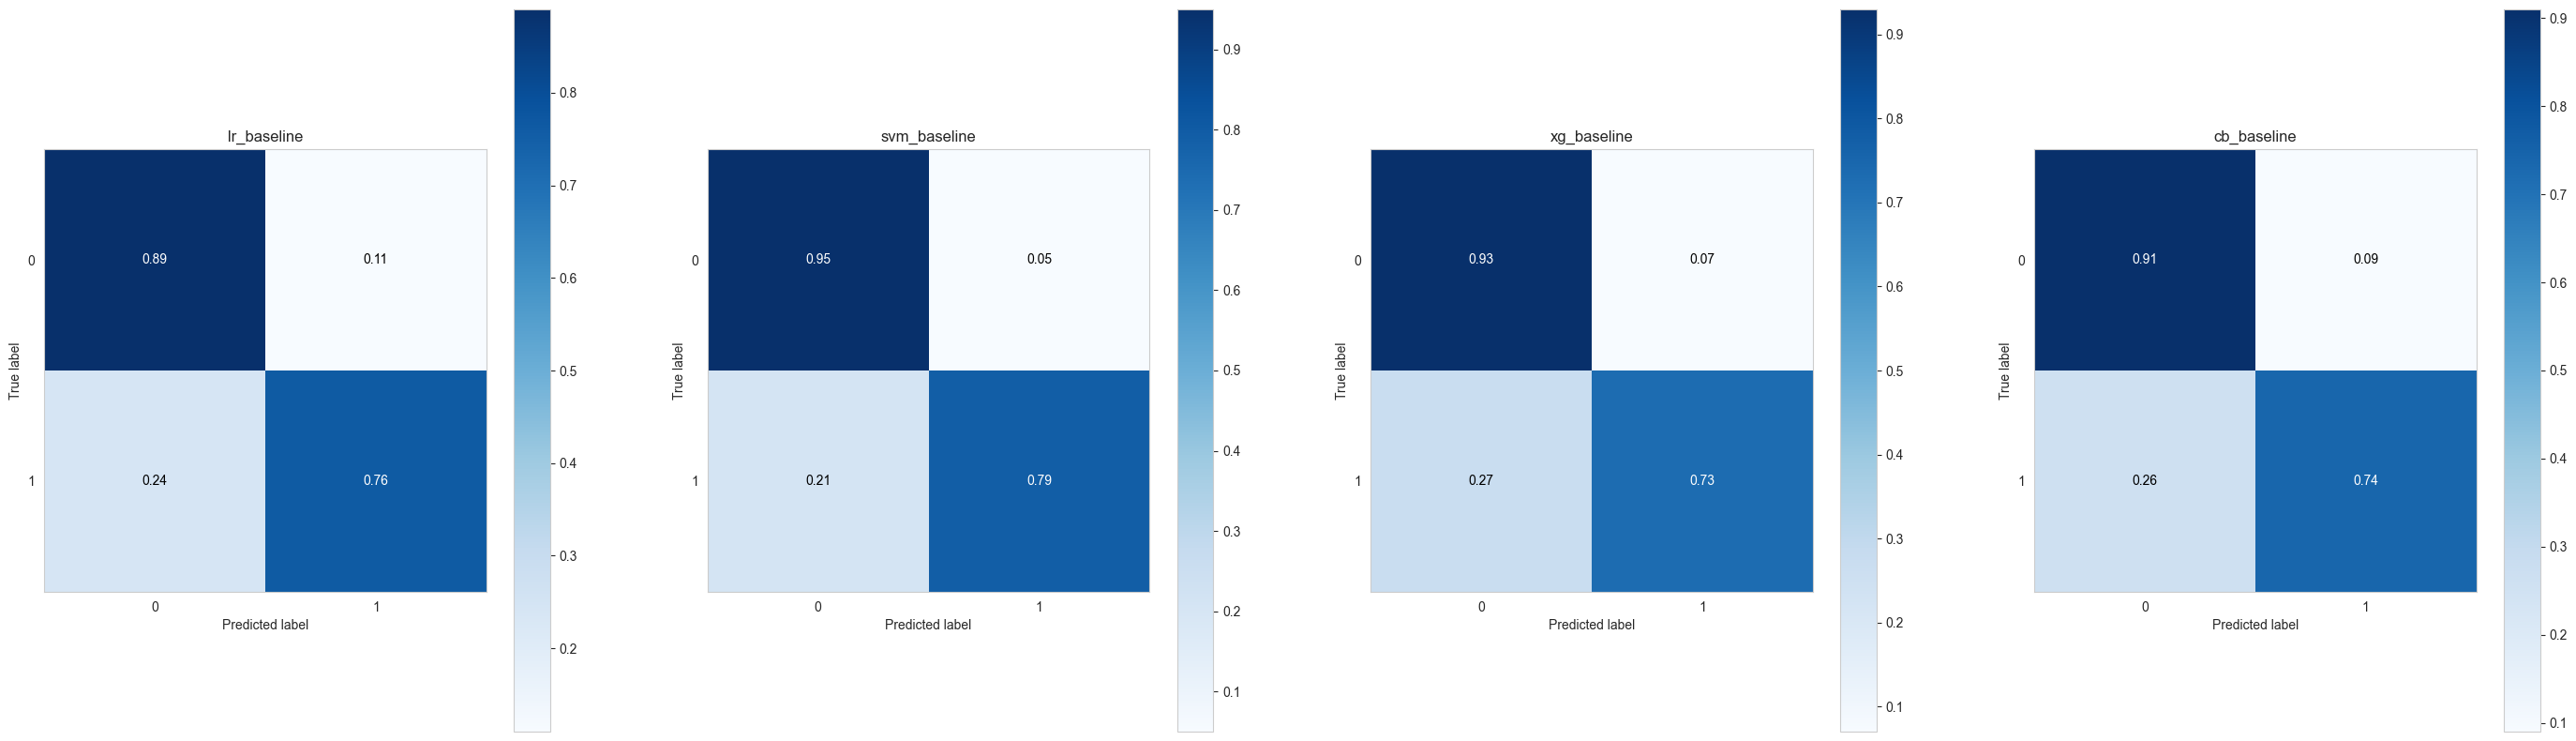

In [61]:
fig = plt.figure(figsize=(35,10))
count=1
for k in models_dict:
    ax = fig.add_subplot(1,len(models_dict),count)
    count+=1
    skplt.metrics.plot_confusion_matrix(y_train, models_dict[k].predict(x_train), normalize=True, figsize=(5,5),ax=ax, cmap="Blues")
    ax.set_title(k)
plt.show()

In [62]:
deploy_acc["lr_baseline"]  = 0.79904
deploy_acc["svm_baseline"] = 0.80382
deploy_acc["xg_baseline"]  = 0.78947
deploy_acc["cb_baseline"]  = 0.79425 
print("Accuracy on the deployment set:")
for k in deploy_acc:
    print(f"{k}\t:\t{deploy_acc[k]}")

Accuracy on the deployment set:
lr_baseline	:	0.79904
svm_baseline	:	0.80382
xg_baseline	:	0.78947
cb_baseline	:	0.79425


In [63]:
print("Accuracy on the training set:")
for k in train_acc:
    print(f"{k}\t:\t{train_acc[k]}")

Accuracy on the training set:
lr_baseline	:	0.8417508417508418
svm_baseline	:	0.8911335578002245
xg_baseline	:	0.8518518518518519
cb_baseline	:	0.8451178451178452


In [64]:
name, model = "ensemble", StackingClassifier(classifiers=(models_dict["svm_baseline"],models_dict["lr_baseline"],
                                                                    models_dict["xg_baseline"], models_dict["cb_baseline"]),
                                               meta_classifier=LogisticRegression(**{"penalty":"l2","solver": "liblinear","C":0.2,}),
                                               use_features_in_secondary=True)
baseline(name, model, verbose=False)

In [65]:
deploy_acc["ensemble"]  = 0.80622

In [66]:
ens_train, ens_deploy = {}, {}
for k in models_dict:
    ens_train[k] = models_dict[k].predict(x_train) * deploy_acc[k]
    ens_deploy[k] = models_dict[k].predict(deploy) * deploy_acc[k]
x_train = pd.concat([pd.DataFrame(ens_train, index=x_train.index),x_train], axis=1)        
deploy = pd.concat([pd.DataFrame(ens_deploy, index=deploy.index),deploy], axis=1)

In [67]:
model = SVC()
model.fit(x_train,y_train)
submition = pd.DataFrame({"PassengerId":deploy.index,"Survived":model.predict(deploy)}).astype(int)

In [68]:
submition.to_csv("submission_dernier_16h.csv",index=False) #0.81100

![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)